In [1]:
import tensorflow as tf
import os

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

In [3]:
%matplotlib inline

In [4]:
def load_mnist_data():
    return input_data.read_data_sets('./mnist_data')

In [5]:
mnist_data = load_mnist_data()

Extracting ./mnist_data/train-images-idx3-ubyte.gz
Extracting ./mnist_data/train-labels-idx1-ubyte.gz
Extracting ./mnist_data/t10k-images-idx3-ubyte.gz
Extracting ./mnist_data/t10k-labels-idx1-ubyte.gz


In [6]:
mnist_data.train.images.shape

(55000, 784)

In [7]:
import matplotlib.pyplot as plt

In [8]:
import numpy as np

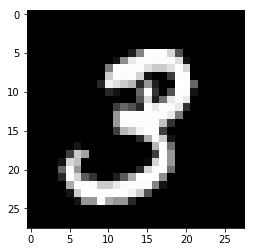

In [9]:
plt.imshow(np.reshape(mnist_data.train.images[1],(28,28)),cmap='gray')

In [10]:
np.reshape(mnist_data.train.images[1],(28,28)) # value:[0,1]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.    

In [11]:
# conv layer , input with batch
def conv(name,input,filter_dims,stride_dims,padding='SAME',non_linearfn=tf.nn.relu):
    input_dims = input.get_shape().as_list()
    assert len(input_dims)==4 # batch_size,height,width,in_channel_nums
    assert len(filter_dims)==3 # height,width,out_channel_nums.
    # default: in_channel_nums of filter = in_channel_nums of input
    assert len(stride_dims)==2 # height,width
    in_channel_nums = input_dims[-1]
    filter_height,filter_width,out_channel_nums = filter_dims
    stride_height,stride_width = stride_dims
    
    with tf.variable_scope(name) as scope:
        conv_kernel = tf.get_variable('kernels',shape=[filter_height,filter_width,in_channel_nums,out_channel_nums]
                                     ,initializer=tf.truncated_normal_initializer(mean=0.01,stddev=0.1))
        biases = tf.get_variable('biases',shape=[out_channel_nums]
                                 ,initializer=tf.truncated_normal_initializer(mean=0.01,stddev=0.1))
        output = tf.nn.conv2d(input,conv_kernel,strides=[1,stride_height,stride_width,1],padding=padding)
        output = tf.nn.bias_add(output,biases)
        return non_linearfn(output,name=scope.name) if non_linearfn else output

In [12]:
def get_deconv2d_output_dims(input_dims, filter_dims, stride_dims, padding):
    # Returns the height and width of the output of a deconvolution layer.
    batch_size, input_h, input_w, num_channels_in = input_dims
    filter_h, filter_w, num_channels_out = filter_dims
    stride_h, stride_w = stride_dims

    # Compute the height in the output, based on the padding.
    if padding == 'SAME':
        out_h = input_h * stride_h
    elif padding == 'VALID':
        out_h = (input_h - 1) * stride_h + filter_h

    # Compute the width in the output, based on the padding.
    if padding == 'SAME':
        out_w = input_w * stride_w
    elif padding == 'VALID':
        out_w = (input_w - 1) * stride_w + filter_w

    return [batch_size, out_h, out_w, num_channels_out]

In [13]:
# deconv layer 
def deconv(name,input,filter_dims,stride_dims,padding='SAME'
           ,non_linearfn=tf.nn.relu):
    input_dims = input.get_shape().as_list()
    assert len(input_dims) == 4
    assert len(filter_dims) == 3
    assert len(stride_dims) == 2
    
    in_channel_nums = input_dims[-1]
    filter_height,filter_width,out_channel_nums = filter_dims
    stride_height,stride_width = stride_dims
    
    output_dims = get_deconv2d_output_dims(input_dims,filter_dims,stride_dims
                                            ,padding)
    with tf.variable_scope(name) as scope:
        kernels = tf.get_variable('kernels'
                                  ,shape=[filter_height,filter_width,out_channel_nums,in_channel_nums]
                                  ,initializer=tf.truncated_normal_initializer(mean=0.01,stddev=0.1))
        biases = tf.get_variable('biases'
                                 ,shape=[out_channel_nums]
                                 ,initializer=tf.truncated_normal_initializer(mean=0.01,stddev=0.1))
        
        output = tf.nn.conv2d_transpose(input,kernels,output_dims,strides=[1,stride_height,stride_width,1],padding=padding)
        
        output = tf.nn.bias_add(output,biases)
        
        return non_linearfn(output) if non_linearfn else output

In [14]:
def max_pool(name, input ,filter_dims, stride_dims, padding='SAME'):
    assert(len(filter_dims) == 2)  # filter height and width
    assert(len(stride_dims) == 2)  # stride height and width

    filter_h, filter_w = filter_dims
    stride_h, stride_w = stride_dims
    
    with tf.variable_scope(name) as scope:
        output = tf.nn.max_pool(input,ksize=[1,filter_h,filter_w,1],strides=[1,stride_h,stride_w,1],padding=padding)
        return output

In [15]:
def fc(name,input,out_dim,non_linearfn=tf.nn.relu):
    assert type(out_dim)==int
    input_dims = input.get_shape().as_list()
    with tf.variable_scope(name) as scope:
        if len(input_dims)==4:
            batch_size,input_h,input_w,in_channel_num = input_dims
            in_dim = input_h*input_w*in_channel_num
            flat_input = tf.reshape(input,shape=[batch_size,in_dim])
        else:
            in_dim = input_dims[-1]
            flat_input = input
        
        weights = tf.get_variable('weights',shape=[in_dim,out_dim],initializer=tf.truncated_normal_initializer())
        biases = tf.get_variable('biases',shape=[out_dim],initializer=tf.truncated_normal_initializer())
        
        output = tf.nn.bias_add(tf.matmul(flat_input,weights),bias=biases)
        return non_linearfn(output) if non_linearfn else output

In [16]:
def encoder(input):
    conv1 = conv('en_conv1',input,[3,3,5],[2,2],padding='VALID')
    conv2 = conv('en_conv2',conv1,filter_dims=[3,3,3],stride_dims=[2,2],padding='SAME')
    conv3 = conv('en_conv3',conv2,filter_dims=[3,3,8],stride_dims=[2,2],padding='SAME')
    return fc('en_fc',input=conv3,out_dim=100,non_linearfn=None)

def decoder(input):
    fc1 = fc('de_fc',input,out_dim=128)
    de_fc = tf.reshape(fc1,shape=[-1,4,4,8])
    deconv1 = deconv('de_conv1',de_fc,filter_dims=[1,1,5],stride_dims=[2,2],padding='SAME') #8x8x5
    deconv2 = deconv('de_conv2',deconv1,filter_dims=[3,3,3],stride_dims=[2,2],padding='VALID') # 17x17x3
    deconv3 = deconv('de_conv3',deconv2,filter_dims=[7,7,2],stride_dims=[1,1],padding='VALID') # 23x23x1
    deconv4 = deconv('de_con4',deconv3,filter_dims=[6,6,1],
                     stride_dims=[1,1],padding='VALID',non_linearfn=tf.nn.sigmoid) # 28x28x1 value:[0,1]
    return deconv4

In [17]:
def autoencoder(input_shape):
    # Define place holder with input shape
    X = tf.placeholder(tf.float32, input_shape)

    # Define variable scope for autoencoder
    with tf.variable_scope('autoencoder') as scope:
        # Pass input to encoder to obtain encoding
        encoding = encoder(X)

        # Pass encoding into decoder to obtain reconstructed image
        decoding = decoder(encoding)

        # Return input image (placeholder) and reconstructed image
    return X, decoding,encoding

In [18]:
def calculate_loss(original, reconstructed):
    loss = tf.reduce_mean(tf.square(original - reconstructed))
    return loss

In [19]:
def get_next_batch(dataset, batch_size,shape):
    # dataset should be mnist.(train/val/test)
    batch, _ = dataset.next_batch(batch_size)
    batch_shape = [batch_size] + shape
    return np.reshape(batch, batch_shape)

In [24]:
def create_summary(loss):
    tf.summary.scalar('loss',loss)
    return tf.summary.merge_all()

In [25]:
def visualize(_original, _reconstructions, num_visualize):
    vis_folder = './vis/'
    if not os.path.exists(vis_folder):
          os.makedirs(vis_folder)

    original = _original[:num_visualize]
    reconstructions = _reconstructions[:num_visualize]
    
    count = 1
    for (orig, rec) in zip(original, reconstructions):
        orig = np.reshape(orig, (28,28))
        rec = np.reshape(rec, (28,28))

        f, ax = plt.subplots(1,2)
        ax[0].imshow(orig, cmap='gray')
        ax[1].imshow(rec, cmap='gray')
        plt.savefig(vis_folder + "test_%d.png" % count)
        count += 1

In [26]:
batch_size = 200
input_shape = (batch_size,28,28,1)

epochs = 10
num_visualize = 10


def train(dataset):
    input_image,reconstructed_image,new_features = autoencoder(input_shape)
    loss = calculate_loss(input_image,reconstructed_image)
    init = tf.global_variables_initializer()
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)
    summries_op = create_summary(loss)
    saver = tf.train.Saver()
    
    with tf.Session() as session:
        try:
            saver.restore(session, "./model/autoencodermodel.ckpt")
            print 'continue'
        except:
            session.run(init)
            print 'init'
        writer = tf.summary.FileWriter('./log',session.graph)
        
        dataset_size = len(dataset.train.images)
        print 'Dataset size :'+str(dataset_size)
        num_batch = dataset_size//batch_size
        for epoch in range(epochs):
            for step in range(num_batch):
                input_batch = get_next_batch(dataset.train,batch_size,[28,28,1])
                summary,loss_val,_ = session.run([summries_op,loss,optimizer],feed_dict={input_image:input_batch})
            writer.add_summary(summary,epoch)
            if epoch%5 == 0:
                print 'Loss at epoch '+str(epoch)+' is '+str(loss_val)
                saver.save(session, "./model/autoencodermodel.ckpt") 
        test_batch = get_next_batch(dataset.test,batch_size,[28,28,1])
        reconstruction = session.run(reconstructed_image,
                                         feed_dict={input_image: test_batch})
        visualize(test_batch, reconstruction, num_visualize)
        writer.close()

INFO:tensorflow:Restoring parameters from ./model/autoencodermodel.ckpt
continue
Dataset size :55000
Loss at epoch 0 is 0.0458599
Loss at epoch 5 is 0.0462292


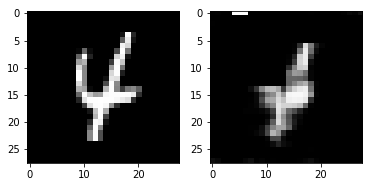

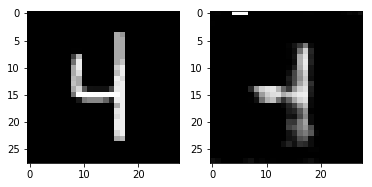

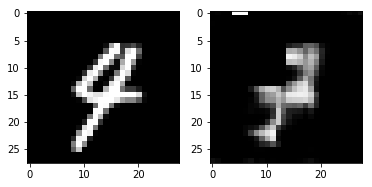

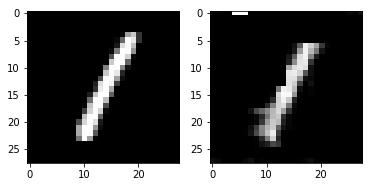

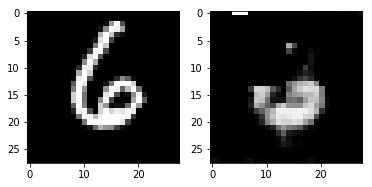

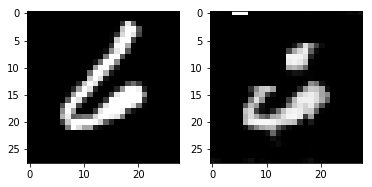

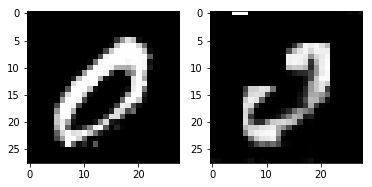

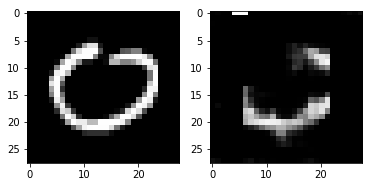

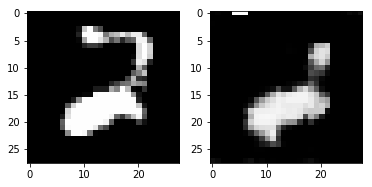

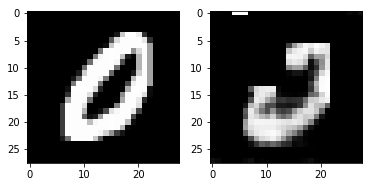

In [27]:
tf.reset_default_graph()
train(mnist_data)

['./vis/test_3.png', './vis/test_9.png', './vis/test_2.png', './vis/test_8.png', './vis/test_10.png', './vis/test_6.png', './vis/test_4.png', './vis/test_1.png', './vis/test_7.png', './vis/test_5.png']


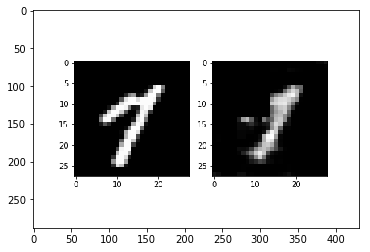

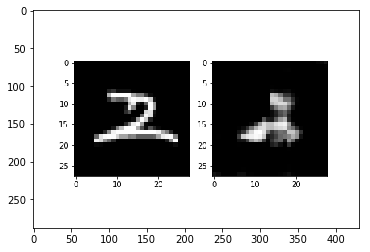

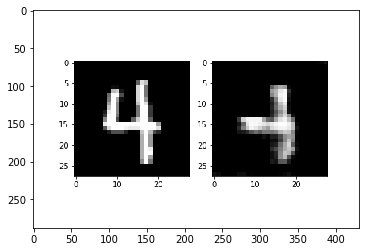

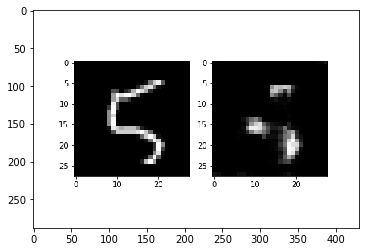

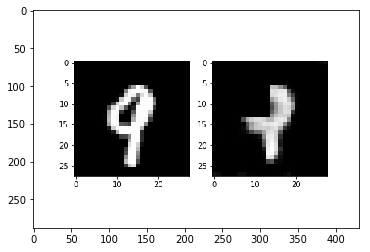

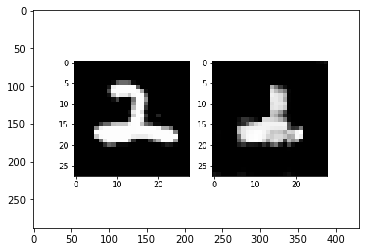

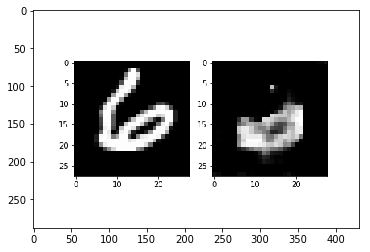

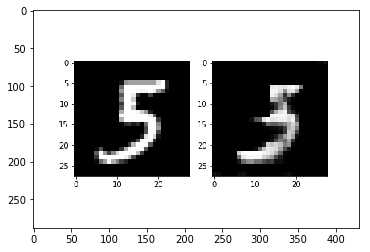

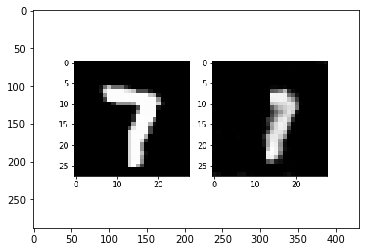

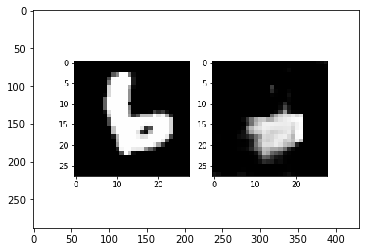

In [25]:
import glob

images = glob.glob("./vis/*.png")
print(images)
for img in images:
    img = plt.imread(img)
    plt.figure()
    plt.imshow(img)

In [1]:
import tensorflow as tf 

a = tf.constant(10,name="a")
b = tf.constant(90,name="b")
y = tf.Variable(a+b*2,name='y')
model = tf.initialize_all_variables()
 
with tf.Session() as session:
    merged = tf.summary.merge_all()
    writer = tf.summary.FileWriter("./tmp/",session.graph)
    session.run(model)
    print(session.run(y))


ImportError: Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/pywrap_tensorflow.py", line 41, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
ImportError: libcudnn.so.6: cannot open shared object file: No such file or directory


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/install_sources#common_installation_problems

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [29]:
import pip 
from subprocess import call 
  
for dist in pip.get_installed_distributions(): 
    print dist
    call("sudo pip install --upgrade " + dist.project_name, shell=True)

widgetsnbextension 2.0.0
Werkzeug 0.12.2
webencodings 0.5.1
wcwidth 0.1.7
urllib3 1.21.1
urllib2 1498656401.94
traitlets 4.3.2
tornado 4.5.1
Theano 0.9.0
testpath 0.3.1
terminado 0.6
tensorflow 0.11.0
tensorflow-gpu 1.2.1
sklearn 0.0
six 1.10.0
singledispatch 3.4.0.3
simplegeneric 0.8.1
setuptools 36.2.4
scipy 0.16.0
scikit-learn 0.18.1
scandir 1.5
requests 2.18.1
qtconsole 4.3.0
pyzmq 16.0.2
PyYAML 3.12
pytz 2017.2
python-dateutil 2.6.1
pyparsing 2.2.0
Pygments 2.2.0
ptyprocess 0.5.2
protobuf 3.3.0
prompt-toolkit 1.0.14
pip 9.0.1
pip-review 0.5.3
pickleshare 0.7.4
pexpect 4.2.1
pbr 3.1.1
pathlib2 2.3.0
pandocfilters 1.4.1
pandas 0.20.3
packaging 16.8
numpy 1.13.1
notebook 5.0.0
nbformat 4.3.0
nbconvert 5.2.1
mock 2.0.0
mistune 0.7.4
MarkupSafe 1.0
Markdown 2.6.8
Keras 2.0.5
jupyter 1.0.0
jupyter-core 4.3.0
jupyter-console 5.1.0
jupyter-client 5.1.0
jsonschema 2.6.0
Jinja2 2.9.6
ipywidgets 6.0.0
ipython 5.4.1
ipython-genutils 0.2.0
ipykernel 4.6.1
idna 2.5
html5lib 0.9999999
h5py 2.7.0